# Deep Learning 教程

主要参考：

- [Training a Simple Neural Network, with PyTorch Data Loading](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)
- [Getting started with JAX (MLPs, CNNs & RNNs)](https://roberttlange.github.io/posts/2020/03/blog-post-10/)
- [From PyTorch to JAX: towards neural net frameworks that purify stateful code](https://sjmielke.com/jax-purify.htm)
- [JAX vs Tensorflow vs Pytorch: Building a Variational Autoencoder (VAE)](https://theaisummer.com/jax-tensorflow-pytorch/)

首先训练一个简单的神经网络。

## Training a Simple Neural Network

首先使用JAX，在MNIST上指定并训练一个简单的MLP。将使用PyTorch的数据加载API加载图像和标签（因为它非常棒，我们不需要另一个数据加载库）。

当然，可以将JAX和与NumPy兼容的任何API一起使用，以使模型更加即插即用。本小节，仅出于说明目的，将不使用任何神经网络库或特殊的API来构建模型。

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

首先，定义超参数

In [2]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
param_scale = 0.1
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

然后定义预测函数。请注意，是为单个图像示例定义的。将使用JAX的vmap功能自动处理mini-batchs，而不会影响性能。

关于其中用到的logesumexp，可以参考[这里](https://blog.feedly.com/tricks-of-the-trade-logsumexp/)

In [3]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def predict(params, image):
    # per-example predictions
    activations = image
    # 最后一层前的几层
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    # 最后一层
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

让我们检查一下适用于单个图像的预测功能。

In [4]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(10,)


In [5]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
try:
    preds = predict(params, random_flattened_images)
except TypeError:
    print('Invalid shapes!')

Invalid shapes!


In [6]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


至此，我们拥有定义神经网络并对其进行训练所需的所有要素。建立了auto-batched 版本的predict，可以在损失函数中使用。后面使用grad能计算loss相对于神经网络参数的导数。还能，使用jit能加速一切。

下面定义效用和损失函数

In [7]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(params, grads)]

使用PyTorch加载数据。JAX专注于程序转换和加速器支持的NumPy，因此JAX库中不包括数据加载或修改。已经有很多出色的数据加载器，所以使用它们而不是重新发明。这里使用PyTorch的数据加载器，并做一个很小的填充以使其与NumPy数组一起使用。

In [8]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle,
                                             sampler=sampler,
                                             batch_sampler=batch_sampler,
                                             num_workers=num_workers, 
                                             collate_fn=numpy_collate,
                                             pin_memory=pin_memory,
                                             drop_last=drop_last,
                                             timeout=timeout,
                                             worker_init_fn=worker_init_fn)
class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))

In [9]:
# Define our dataset, using torch datasets
# 把图像展开成一维
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

In [10]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/home/owen411/miniconda3/envs/elks/lib/python3.9/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/owen411/miniconda3/envs/elks/lib/python3.9/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/owen411/miniconda3/envs/elks/lib/python3.9/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/owen411/miniconda3/envs/elks/lib/python3.9/site-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


训练循环

In [11]:
import time

for epoch in range(num_epochs):
    start_time = time.time()
    for x, y in training_generator:
        y = one_hot(y, n_targets)
        params = update(params, x, y)
    epoch_time = time.time() - start_time
    
    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

Epoch 0 in 8.03 sec
Training set accuracy 0.9158166646957397
Test set accuracy 0.919700026512146
Epoch 1 in 4.87 sec
Training set accuracy 0.9371833205223083
Test set accuracy 0.9384999871253967
Epoch 2 in 4.54 sec
Training set accuracy 0.9492166638374329
Test set accuracy 0.9470000267028809
Epoch 3 in 4.19 sec
Training set accuracy 0.9567166566848755
Test set accuracy 0.9532999992370605
Epoch 4 in 4.41 sec
Training set accuracy 0.9630500078201294
Test set accuracy 0.957099974155426
Epoch 5 in 4.51 sec
Training set accuracy 0.9674500226974487
Test set accuracy 0.9617999792098999
Epoch 6 in 4.19 sec
Training set accuracy 0.97079998254776
Test set accuracy 0.9652000069618225
Epoch 7 in 4.67 sec
Training set accuracy 0.9737833142280579
Test set accuracy 0.9672999978065491


现在，我们已经使用了整个JAX API：grad求导，jit加速，vmap自动矢量化。使用NumPy来指定所有的计算，并从PyTorch借用了出色的数据加载器，然后运行了整个程序。

下面看看一个经典的循环神经网络在JAX中应该如何实现。

## Getting started with JAX (RNNs)

在Jax中实现RNN，需要做一些特别处理。道理上说是一切皆有可能，但这块还是需要更多脑细胞来处理。此外，就编译而言，for循环是有些令人讨厌的。不过，也能找出解决方法。在接下来的内容中，就尝试学习使用门控循环单元（GRU）网络预测Ornstein-Uhlenbeck（OU）过程（可以不管具体是什么，总之是一个时间序列过程）的嘈杂版本的下一个去噪值。

先生成一些数据：使用传统的NumPy来生成一个Ornstein-Uhlenbeck过程。首先顺序生成OU时间序列，然后在顶部添加高斯噪声。稍后，RNN将尝试去噪这一嘈杂的OU，并恢复原始时间序列。

下面helper模块在本文件夹下，代码来自这里：https://github.com/RobertTLange/code-and-blog/tree/master/04_jax_intro

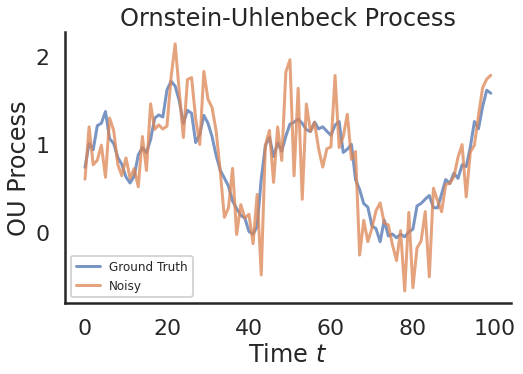

In [1]:
# Generate & plot a time series generated by the OU process
from helpers import generate_ou_process, plot_ou_process
x_0, mu, tau, sigma, dt = 0, 1, 2, 0.5, 0.1
noise_std = 0.1
num_dims, batch_size = 100, 50  # Number of timesteps in process

x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau,
                                 sigma, noise_std, dt)
plot_ou_process(x[0, :], x_tilde[0, :])

现在定义GRU层，主要就是定义 hidden state 更新公式。

- 更新门：$z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$
- 重置门：$r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$
- 隐含状态：$h_z = z_t \circ h_{t-1} + (1-z_t) \circ tanh(W_h x_t + U_h (r_t \circ h_{t-1} + b_h)$

最终要学习的权重矩阵和偏差是：$W_z, U_z, b_z, W_r, U_r, b_r, W_h, U_h, b_h$

首先导入相关包，接下来np指的就是jax的numpy，普通numpy用onp表示。

In [2]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

In [3]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (Dense, Relu)

稍微介绍一下stax。和PyTorch和Tensorflow类似，Jax提供了一个抽象层来方便使用神经网络--stax。stax是jax的一个很简洁的，从头开始构建的神经网络架构。

stax API已有一组预定义的输入变化，这些输入变化可以直接拿来用。比如Dense，ReLU等，几乎包括所有标准前馈运算。我们可以使用stax.serial包装器将它们链接起来。就像在pytorch和tensorflow中定义类似Sequential的操作一样。serial会返回一个新的 layer,是一个 (init_fun, apply_fun) 对子，表示给定序列的层的序列组成，即所有层init函数的组合和实际前向计算函数的组合。下面会看到具体实例。

stax中jax的神经网络函数定义结构是类似的，有一个子函数可以初始化各层的参数，另一个子函数apply_fun可以在给定层参数的情况下对输入进行转换。

- 初始化函数的参数一个是种子的key，一个是 input_shape（三维：batch_size, num_dims, 1，和pytorch中一样，就是batch/sequence/feature）。init_fun 函数目的就是初始化最终要学习的参数的值，初始化的时候，jax的随机种子和numpy的不同，前面已经有记录，这里不赘述了。glorot_normal就是Xavier normal，和输入输出尺寸相关的正态随机。normal就是一般正态随机。返回值包括output_shape，hidden还有params。
- apply_fun 就是对输入序列进行循环计算，其参数包括params, inputs，隐含层放到params中。返回的是更新的隐含层。

初始化函数 normal() 执行的是标准正态分布，标准正态分布是从均匀分布计算来的：np.array(np.sqrt(2)) * lax.erf_inv(random.uniform(key, shape, dtype, -1, 1))。lax.erf_inv 就是lax包中的逆误差函数。误差函数是一种特殊的函数，可以参考[这里](https://zh.wikipedia.org/wiki/%E8%AF%AF%E5%B7%AE%E5%87%BD%E6%95%B0)。

初始化里面，根据[这里](https://stats.stackexchange.com/questions/229669/when-should-i-use-the-normal-distribution-or-the-uniform-distribution-when-using)的介绍，为了保证输入和输出的方差尽可能一致，使得梯度不至于消失或者爆炸，才能使神经网络较好地训练。所以通常不是将网络权重直接初始化为正态分布值，通常需要再乘以一个系数，不同的方法系数不同，比如Xavier方法（也称为glorot方法）或Kaiming方法（也称为He方法）。

**RNN中计算的特殊之处在于，我们必须跟踪隐藏状态**。这里是通过将隐藏状态$h_t$定义为params字典中的参数来完成的。这样的一个好处（或问题）是，我们也学习了初始的隐藏状态（apply_fun函数第一行代码 h = params[0]）。

此外，如果我们简单地写一个for循环以在多个时间步上执行RNN，就会遇到麻烦。这是因为JAX会尝试在每个时间步编译相关函数。这可能需要一段时间。为了克服这个问题，我们必须使用lax.scan。因为scan 是一个JAX的原生函数，相比于python原生循环，能大大减少编译时间。

> scan is a JAX primitive and is lowered to a single XLA While HLO. That makes it useful for reducing compilation times for jit-compiled functions, since native Python loop constructs in an @jit function are unrolled, leading to large XLA computations. - ReadTheDocs

为了利用这样一个功能强大的工具，需要定义一个单步的时间步更新，这是在apply_fun_scan中完成的，其执行的具体运算就是上面记录的三个公式。

使用partial来clone在所有时间步使用的所有参数。partial的作用就是返回一个函数，这个函数在被调用的时候会把第一个参数（函数）作用到第二个参数和调用的对象上。

In [4]:
def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]

        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W)
                                  + np.dot(np.multiply(reset_gate, hidden), out_U)
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0 移动第二维到第一维，其他不变，所以就相当于第一维和第二维换位置了
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun

现在可以“实例化”RNN和所有必需的成分。这里例子选择具有12维的隐藏状态。

用均方误差作损失函数。损失函数定义中执行了一次前向计算，因为本来就是函数式编程，所以很方便，直接就能使用gru_rnn计算了。

update函数参数是params，输入和输出，以及状态更新，opt_state是优化器的状态，更新的时候也需要更新它，是它带着参数的优化的（update函数中有get_params(opt_state)来获取更新后的参数）。函数中执行 value_and_grad 函数计算函数值的同时，也计算函数的梯度。所以返回值一个是loss，一个是grads。

opt_update，get_params都是优化器的函数，需要进一步定义。

In [5]:
key = random.PRNGKey(1)
num_dims = 10              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 12      # GRU cells in the RNN layer

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                GRU(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    return np.mean((preds - targets)**2)

# 没有jit会非常慢
@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

output_shape 后续没有用到，所以直接赋值到_，可以看到，shape和input的是一样的。

In [6]:
_

(64, 10, 1)

params现在已经是serial后多层结构的网络的参数了，因为有四层，所以是len为4的tuple。GRU的参数在第三个，如上面定义中的代码所示，其也是一个tuple，len为4.

In [7]:
len(params[2])

4

查看其中，update_W的维度，可以看到是二维数组。W的维度，行是对应Wx+b的输出的维度大小，列是对应x的feature的大小。

In [8]:
params[2][1][0].shape

(12, 12)

下面开始训练GRU-RNN来学习预测Ornstein-Uhlenbeck过程的数据生成过程。最初可能无法是无其他帮助的条件下端到端地生成整个过程序列 $x_1, x_2, …, x_T$ 。因此，我们将利用一种称为“teacher forcing”的技术。

![](pictures/teacher_forcing.png)

在teacher forcing中，不仅使用下一步的 $x_{t+1}$ 来计算预测损失（例如均方误差），还将其作为下一时间步的输入。

在本示例中，我们希望网络学习去噪，因此，使用的不是去噪的OU版本$x_{t+1}$而是有噪音的$\tilde{x}_{t+1}$作为输入，有助于其学习过程。

稍后，在网络学习了部分生成动态信息之后，我们可以禁用teacher forcing，并让网络生成整个序列。

首先定义优化器，选择优化算法，并定义步长。

优化算法定义了三个函数并返回。以随机梯度下降算法为例，返回的opt_init函数负责返回初始化给的参数；opt_update 函数负责使用优化算法更新参数；get_params函数则负责从opt_update运算后的结果中取出更新后的参数。源码中使用了很多decorator来包装函数，所以稍微不太容易看懂。

In [9]:
step_size = 1e-4
# opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_init, opt_update, get_params = optimizers.sgd(step_size)
opt_state = opt_init(params)

定义batches个数

In [10]:
num_batches = 1000

开始训练

In [18]:
import time

train_loss_log = []
start_time = time.time()
for batch_idx in range(num_batches):
    # 生成训练样本，x是要找的 ou_process，包括训练的输出；x_tilde是加了噪音的，是训练的输入 
    x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
    x_in = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
    y = np.array(x[:, 1:])
    params, opt_state, loss = update(params, x_in, y, opt_state)
    batch_time = time.time() - start_time
    train_loss_log.append(loss)

    if batch_idx % 100 == 0:
        start_time = time.time()
        print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))

Batch 0 | T: 2.32 | MSE: 0.55 |
Batch 100 | T: 0.30 | MSE: 0.48 |
Batch 200 | T: 0.10 | MSE: 0.32 |
Batch 300 | T: 0.11 | MSE: 0.41 |
Batch 400 | T: 0.09 | MSE: 0.40 |
Batch 500 | T: 0.10 | MSE: 0.31 |
Batch 600 | T: 0.11 | MSE: 0.25 |
Batch 700 | T: 0.10 | MSE: 0.31 |
Batch 800 | T: 0.09 | MSE: 0.24 |
Batch 900 | T: 0.11 | MSE: 0.17 |


In [19]:
x_tilde.shape

(64, 10)

In [20]:
x_in.shape

(64, 9, 1)

由于函数内部有另外的在外面定义好的函数，所以如果想要把上面的函数封装起来，需要写一个大函数把它们全部包起来。

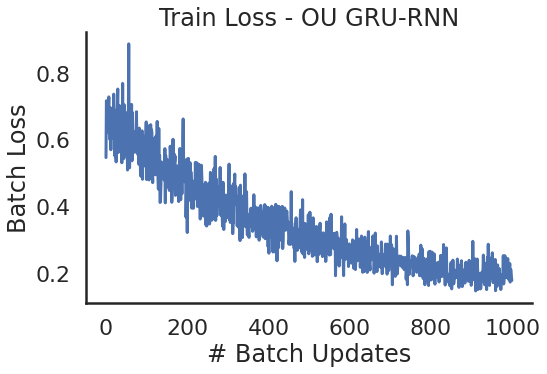

In [21]:
# Plot the training loss for OU-GRU-RNN!
from helpers import plot_ou_loss
plot_ou_loss(train_loss_log)

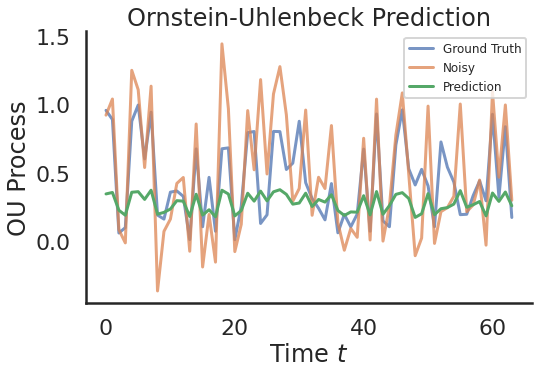

In [22]:
# Plot a prediction and ground truth OU process
x_true, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
x = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
y = np.array(x[:, 1:])
preds = gru_rnn(params, x)

x = onp.array(x)
y = onp.array(y)
x_pred = onp.array(preds)
plot_ou_process(x_true[:, 0], x_tilde=x_tilde[:, 0], x_pred=x_pred[0, :],
               title=r"Ornstein-Uhlenbeck Prediction")

## From PyTorch to JAX

在开始基于JAX的神经网络之前，有必要了解下 JAX 和 PyTorch之间的区别。

关注JAX，主要是因为其高性能的Numpy以及自动微分，即计算某些损失函数相对于输入参数的梯度。但是从PyTorch或Tensorflow 2转到JAX不是一个小变化：建立计算的基本方法，以及更重要的进行反向传播的方式在他们之间是有根本不同的！当前向计算时，PyTorch会建立一个计算图，然后其backward()对某个“结果”节点进行一次调用，然后使用结果节点相对于该中间节点的梯度来加强图中的每个中间节点。而JAX则将计算表示为Python函数，并通过grad()对其进行转换来提供梯度函数，您可以像普通计算函数一样对梯度函数进行求值-输出相对于函数输入的第一个参数（默认）的梯度：

![](pictures/comparison_small.png)

当然，这会对如何在两个框架中编写代码和建立模型有影响。因此，当习惯于PyTorch或Tensorflow 2中的自动微分且使用有状态对象时，转到JAX可能会有些不习惯。

如果查看flax，trax或haiku的库，看到某些神经网络的示例，看起来与其他任何框架也不是太不相似，都是定义一些层，运行一些trainers... 但是里面究竟发生了什么？从小的numpy函数到训练大型分层神经网络的路线是什么？还是值得了解下的。

本小节我们将：

1. 快速回顾基于反向自动微分框架PyTorch的有状态LSTM-LM的实现，
2. 了解PyTorch风格的编码如何依赖于可变状态，了解不可变的纯函数并在JAX中构建（纯）zappy单层代码，
3. 将各个参数注册为pytree节点，逐步将它们从单个参数扩展到中等大小的模块，
4. 通过构建精美的脚手架并控制上下文以提取初始化参数来净化函数，从而消除增长的痛苦
5. 意识到我们可以使用DeepMind的transform机制在诸如DeepMind的haiku框架中轻松实现这一目标。

待记录。。。

## JAX下的深度学习库

根据 https://github.com/google/jax#neural-network-libraries 的说明，有多个Google的研究组使用JAX开发了神经网络库，比如 [Flax](https://github.com/google/flax)，[Trax](https://github.com/google/trax)，[Objax](https://github.com/google/objax)；DeepMind也有[基于JAX的开源生态](https://deepmind.com/blog/article/using-jax-to-accelerate-our-research)，包括[Haiku](https://github.com/deepmind/dm-haiku)，[Optax](https://github.com/deepmind/optax)，[RLax](https://github.com/deepmind/rlax)，以及[Chex](https://github.com/deepmind/chex)

如果想要一个具有示例和操作指南的功能齐全的神经网络训练库，请尝试 Flax；另一个选择是 Trax；它是一个基于组合器的框架，专注于易用性和端到端的单命令示例，特别是针对序列模型和强化学习的示例；Objax是具有PyTorch式界面的简约的面向对象框架。

Haiku 用于神经网络的模块；Optax梯度处理和优化；RLax为RL算法；Chex用于可靠代码和测试。

个人认为选择 Flax 开始更容易上手。

待记录。。。